# **Chest X-Ray Classifications**

In [1]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d /content/chest_xray


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  


# **Pre-Process the Data**

In [2]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
import seaborn as sns
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from transformers import ViTForImageClassification, ViTImageProcessor
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# paths
dataset_dir = "/content/chest_xray/chest_xray"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random changes in color
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize to simulate zoom
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Small random translations and rotations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformTest = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transformTest)
test_dataset = datasets.ImageFolder(test_dir, transform=transformTest)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




# **Augmented vs Real Images**

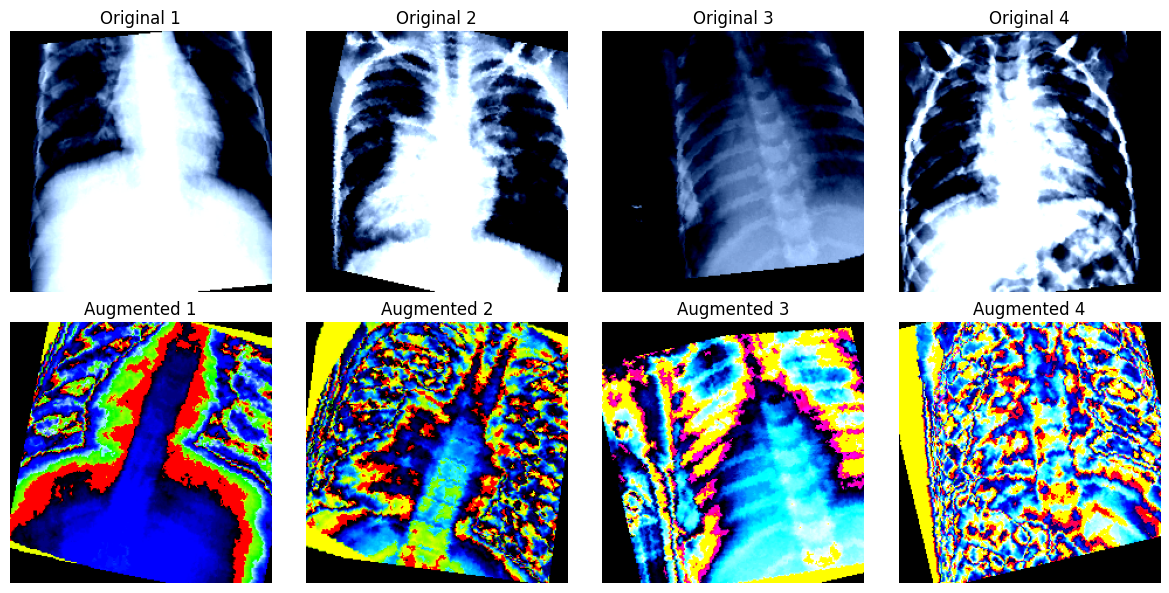

In [ ]:
def imshow(tensor, unnormalize=False):
    np_image = tensor.numpy().transpose((1, 2, 0))
    if unnormalize:
        np_image = np.clip(np_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(np_image)
    plt.axis('off')

data_iter = iter(train_loader)
images, labels = next(data_iter)
images_4 = images[:4]
pil_images = [F.to_pil_image(image) for image in images_4]
augmented_images = [transform(image) for image in pil_images]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(images_4[i].numpy().transpose((1, 2, 0)))
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
for i in range(4):
    axes[1, i].imshow(augmented_images[i].numpy().transpose((1, 2, 0)))
    axes[1, i].set_title(f"Augmented {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# **Defining the Models**

In [3]:
class ComplexCNNModel(nn.Module):
    def __init__(self):
        super(ComplexCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

def create_resnet_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model


def create_vgg_model():
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model


# **CNN MODEL**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.7MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.4MB/s]



Training Custom CNN:
Epoch 1/5


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Custom CNN Training Loss: 0.4378 | Validation Loss: 0.5373
Epoch 2/5


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Custom CNN Training Loss: 0.3083 | Validation Loss: 0.6781
Epoch 3/5


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Custom CNN Training Loss: 0.2542 | Validation Loss: 0.5867
Epoch 4/5


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Custom CNN Training Loss: 0.2332 | Validation Loss: 0.7409
Epoch 5/5


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Custom CNN Training Loss: 0.1963 | Validation Loss: 0.6532

Testing Custom CNN:


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Custom CNN Test Accuracy: 0.8910


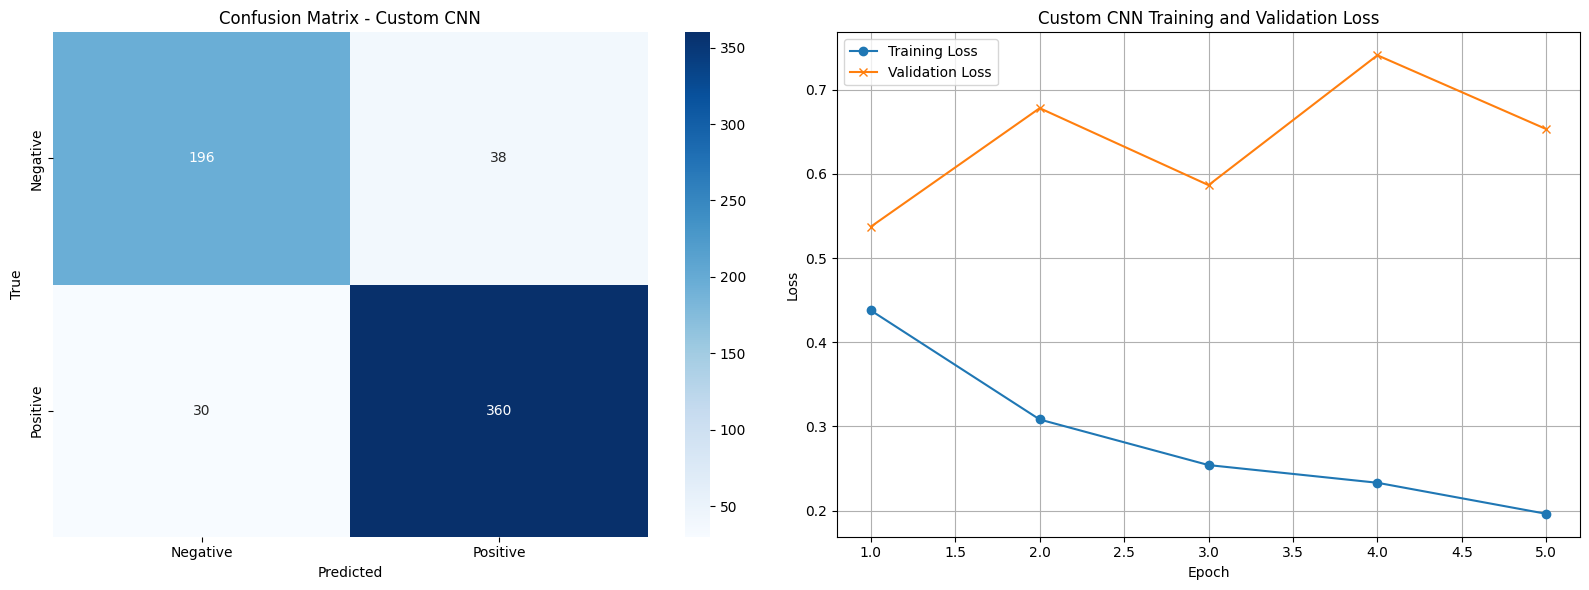

In [ ]:

def train_loop(model, criterion, optimizer, train_loader):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def val_loop(model, criterion, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

def test_loop(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
            outputs = model(images)
            preds = (outputs > 0.5).int()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(test_labels, test_preds)
    cm = confusion_matrix(test_labels, test_preds)
    return accuracy, cm

# models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = ComplexCNNModel().to(device)
model_resnet = create_resnet_model().to(device)
model_vgg = create_vgg_model().to(device)

criterion = nn.BCELoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)

num_epochs = 3
train_losses_cnn, val_losses_cnn = [], []
train_losses_resnet, val_losses_resnet = [], []
train_losses_vgg, val_losses_vgg = [], []

def plot_loss_and_confusion_matrix_side_by_side(model_name, train_losses, val_losses, cm, num_epochs):
    """
    Function to plot the training and validation loss alongside the confusion matrix for a single model.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=axes[0])
    axes[0].set_title(f"Confusion Matrix - {model_name}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Plot loss graph
    axes[1].plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    axes[1].plot(range(1, num_epochs + 1), val_losses, marker='x', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"{model_name} Training and Validation Loss")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()



# Train Custom CNN
print("\nTraining Custom CNN:")
for epoch in range(5):
    print(f"Epoch {epoch + 1}/{5}")
    train_loss_cnn = train_loop(model_cnn, criterion, optimizer_cnn, train_loader)
    val_loss_cnn = val_loop(model_cnn, criterion, val_loader)
    train_losses_cnn.append(train_loss_cnn)
    val_losses_cnn.append(val_loss_cnn)
    print(f"Custom CNN Training Loss: {train_loss_cnn:.4f} | Validation Loss: {val_loss_cnn:.4f}")
print("\nTesting Custom CNN:")
test_accuracy_cnn, cm_cnn = test_loop(model_cnn, test_loader)
print(f"Custom CNN Test Accuracy: {test_accuracy_cnn:.4f}")
plot_loss_and_confusion_matrix_side_by_side("Custom CNN", train_losses_cnn, val_losses_cnn, cm_cnn, 5)





# **ResNet Model**


Training ResNet:
Epoch 1/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


ResNet Training Loss: 0.2020 | Validation Loss: 0.3272
Epoch 2/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


ResNet Training Loss: 0.1394 | Validation Loss: 0.7316
Epoch 3/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


ResNet Training Loss: 0.1348 | Validation Loss: 0.4398

Testing ResNet:


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


ResNet Test Accuracy: 0.9119


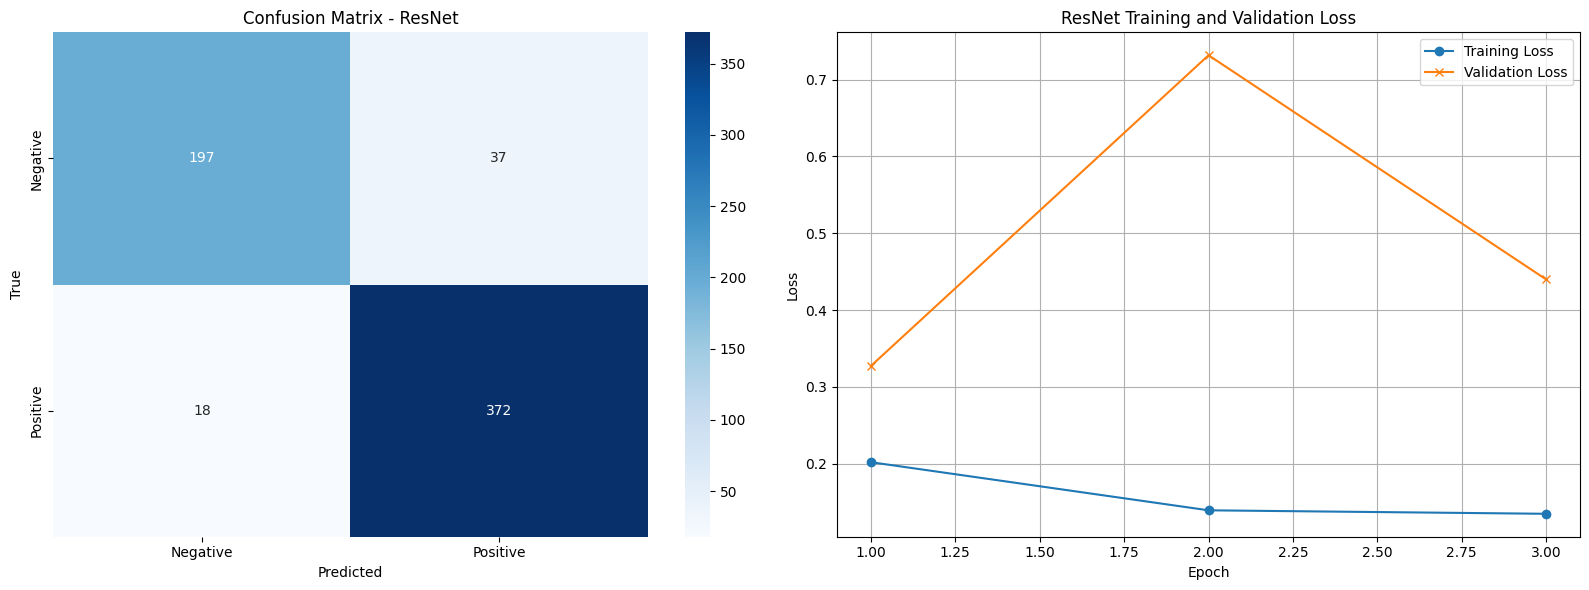

In [ ]:
# Train ResNet
print("\nTraining ResNet:")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss_resnet = train_loop(model_resnet, criterion, optimizer_resnet, train_loader)
    val_loss_resnet = val_loop(model_resnet, criterion, val_loader)
    train_losses_resnet.append(train_loss_resnet)
    val_losses_resnet.append(val_loss_resnet)
    print(f"ResNet Training Loss: {train_loss_resnet:.4f} | Validation Loss: {val_loss_resnet:.4f}")
print("\nTesting ResNet:")
test_accuracy_resnet, cm_resnet = test_loop(model_resnet, test_loader)
print(f"ResNet Test Accuracy: {test_accuracy_resnet:.4f}")
plot_loss_and_confusion_matrix_side_by_side("ResNet", train_losses_resnet, val_losses_resnet, cm_resnet, num_epochs)


# **VGG Model**


Training VGG:
Epoch 1/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


VGG Training Loss: 0.8786 | Validation Loss: 0.7069
Epoch 2/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


VGG Training Loss: 0.5881 | Validation Loss: 0.7678
Epoch 3/3


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


VGG Training Loss: 0.5757 | Validation Loss: 0.8370

Testing VGG:


Testing: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


VGG Test Accuracy: 0.6250


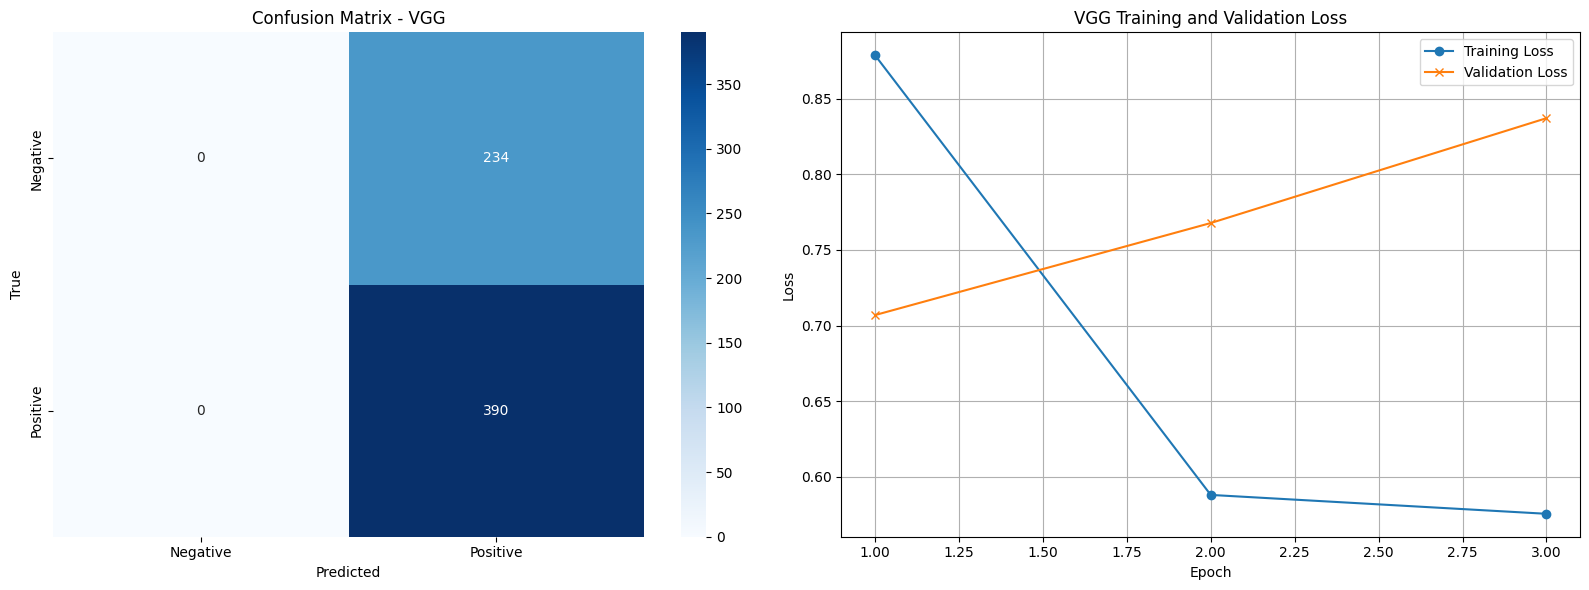

In [ ]:
# Train VGG
print("\nTraining VGG:")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss_vgg = train_loop(model_vgg, criterion, optimizer_vgg, train_loader)
    val_loss_vgg = val_loop(model_vgg, criterion, val_loader)
    train_losses_vgg.append(train_loss_vgg)
    val_losses_vgg.append(val_loss_vgg)
    print(f"VGG Training Loss: {train_loss_vgg:.4f} | Validation Loss: {val_loss_vgg:.4f}")
print("\nTesting VGG:")
test_accuracy_vgg, cm_vgg = test_loop(model_vgg, test_loader)
print(f"VGG Test Accuracy: {test_accuracy_vgg:.4f}")
plot_loss_and_confusion_matrix_side_by_side("VGG", train_losses_vgg, val_losses_vgg, cm_vgg, num_epochs)


# **ViT Model**

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Epoch 1/3 - Training: 100%|██████████| 163/163 [04:43<00:00,  1.74s/it]


Epoch 1/3, Training Loss: 0.1879, Training Accuracy: 0.9294


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 1/3, Validation Loss: 0.3479, Validation Accuracy: 0.8750


Epoch 2/3 - Training: 100%|██████████| 163/163 [04:43<00:00,  1.74s/it]


Epoch 2/3, Training Loss: 0.1039, Training Accuracy: 0.9632


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 2/3, Validation Loss: 0.4772, Validation Accuracy: 0.6250


Epoch 3/3 - Training: 100%|██████████| 163/163 [04:42<00:00,  1.74s/it]


Epoch 3/3, Training Loss: 0.1013, Training Accuracy: 0.9663


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch 3/3, Validation Loss: 0.2656, Validation Accuracy: 0.8750


Testing: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Test Accuracy: 0.9167


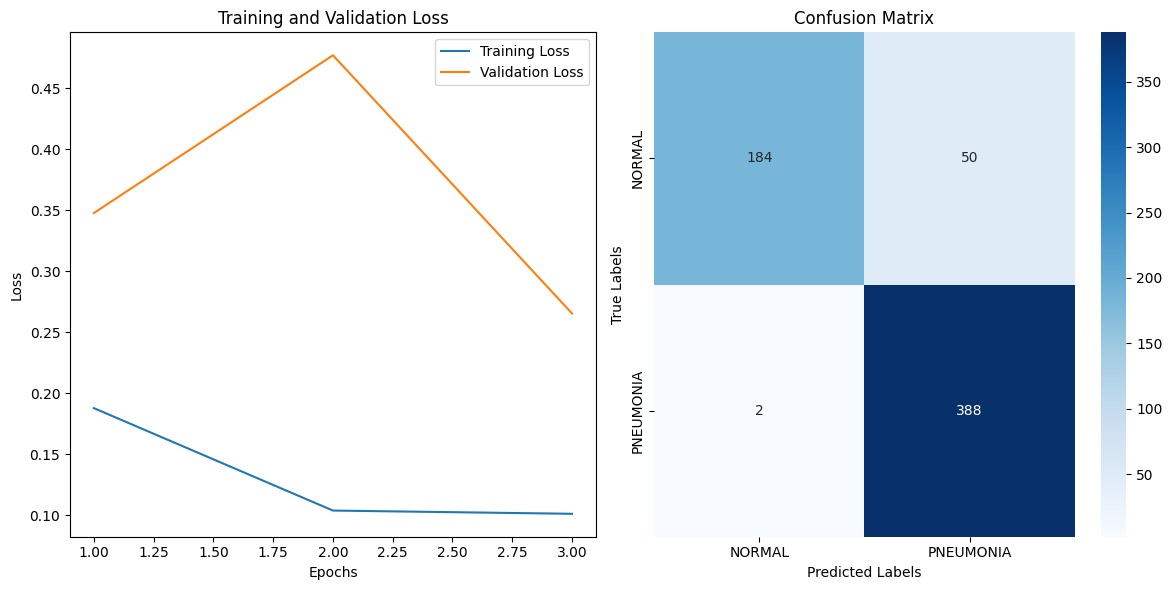

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train_dataset.classes)
)
model.to(device)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 3
best_accuracy = 0.0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_vit_model.pth")

# Testing
model.load_state_dict(torch.load("best_vit_model.pth"))
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images, labels=labels)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy_VIT = correct / total
print(f"Test Accuracy: {test_accuracy_VIT:.4f}")

plt.figure(figsize=(12, 6))

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")

plt.tight_layout()
plt.show()


# **Models Results**

In [ ]:
lst = [test_accuracy_cnn, test_accuracy_resnet, test_accuracy_vgg, test_accuracy_VIT]
model_names = ["CNN", "ResNet", "VGG", "ViT"]
df = pd.DataFrame({"Model": model_names, "Accuracy": lst})
df

,Model,Accuracy
0,CNN,0.891026
1,ResNet,0.911859
2,VGG,0.625000
3,ViT,0.916667


# **Fine-Tuning ResNet Model**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = create_resnet_model().to(device)
criterion = nn.BCELoss()
learning_rates = [0.001, 0.0001, 0.01]
batch_sizes = [16, 32, 64]
num_epochs = 3
experiment_results = []
best_model_details = None
best_test_accuracy = 0.0

# Experiment loop
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining with batch size {batch_size} and learning rate {lr}...")

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Optimizer and Scheduler
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        # Training and Validation Phase
        train_losses, val_losses = [], []
        for epoch in range(num_epochs):
            model.train()
            train_loss, correct, total = 0.0, 0, 0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_loss /= len(train_loader)
            train_accuracy = correct / total
            train_losses.append(train_loss)

            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    predicted = (outputs > 0.5).float()
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_accuracy = correct / total
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            scheduler.step()

        # Evaluate on Test Set
        model.eval()
        correct, total = 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        test_accuracy = correct / total
        print(f"Test Accuracy for batch_size={batch_size}, lr={lr}: {test_accuracy:.4f}")

        experiment_results.append({
            "Batch Size": batch_size,
            "Learning Rate": lr,
            "Test Accuracy": test_accuracy
        })

        # Save the best model based on test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), f"best_resnet_model_batch_{batch_size}_lr_{lr}_test.pth")
            best_model_details = {
                "Batch Size": batch_size,
                "Learning Rate": lr,
                "Test Accuracy": test_accuracy,
                "Train Loss History": train_losses,
                "Validation Loss History": val_losses,
                "All Labels": all_labels,
                "All Predictions": all_preds
            }

# Display Experiment Results
results_df = pd.DataFrame(experiment_results)
print("\nExperiment Results:")
results_df




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.4MB/s]



Training with batch size 16 and learning rate 0.001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch 1/3, Train Loss: 0.2413, Val Loss: 0.5709, Val Accuracy: 0.6875


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 2/3, Train Loss: 0.1795, Val Loss: 0.3351, Val Accuracy: 0.8125


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 3/3, Train Loss: 0.1669, Val Loss: 1.8572, Val Accuracy: 0.6250


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test Accuracy for batch_size=16, lr=0.001: 0.8702

Training with batch size 16 and learning rate 0.0001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 1/3, Train Loss: 0.1138, Val Loss: 0.4500, Val Accuracy: 0.7500


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 2/3, Train Loss: 0.1035, Val Loss: 0.3564, Val Accuracy: 0.8125


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 3/3, Train Loss: 0.0976, Val Loss: 0.2125, Val Accuracy: 0.9375


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test Accuracy for batch_size=16, lr=0.0001: 0.9423

Training with batch size 16 and learning rate 0.01...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch 1/3, Train Loss: 0.5976, Val Loss: 2.7848, Val Accuracy: 0.5000


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 2/3, Train Loss: 0.3507, Val Loss: 0.7423, Val Accuracy: 0.5000


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch 3/3, Train Loss: 0.3404, Val Loss: 0.7638, Val Accuracy: 0.5000


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test Accuracy for batch_size=16, lr=0.01: 0.4615

Training with batch size 32 and learning rate 0.001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 1/3, Train Loss: 0.2588, Val Loss: 0.9714, Val Accuracy: 0.6250


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 2/3, Train Loss: 0.2481, Val Loss: 1.6489, Val Accuracy: 0.5625


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 3/3, Train Loss: 0.2330, Val Loss: 1.5307, Val Accuracy: 0.5625


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test Accuracy for batch_size=32, lr=0.001: 0.8638

Training with batch size 32 and learning rate 0.0001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch 1/3, Train Loss: 0.2170, Val Loss: 1.4000, Val Accuracy: 0.5000


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 2/3, Train Loss: 0.2122, Val Loss: 1.3626, Val Accuracy: 0.5000


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch 3/3, Train Loss: 0.2167, Val Loss: 1.3669, Val Accuracy: 0.5625


Testing: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test Accuracy for batch_size=32, lr=0.0001: 0.8798

Training with batch size 32 and learning rate 0.01...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch 1/3, Train Loss: 0.2763, Val Loss: 2.8611, Val Accuracy: 0.5625


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 2/3, Train Loss: 0.2499, Val Loss: 2.0903, Val Accuracy: 0.6875


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch 3/3, Train Loss: 0.2504, Val Loss: 1.2075, Val Accuracy: 0.5625


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Test Accuracy for batch_size=32, lr=0.01: 0.8622

Training with batch size 64 and learning rate 0.001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 1/3, Train Loss: 0.2066, Val Loss: 1.1896, Val Accuracy: 0.5625


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 2/3, Train Loss: 0.1890, Val Loss: 1.4523, Val Accuracy: 0.5625


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 3/3, Train Loss: 0.1897, Val Loss: 0.9417, Val Accuracy: 0.6250


Testing: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Test Accuracy for batch_size=64, lr=0.001: 0.8622

Training with batch size 64 and learning rate 0.0001...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch 1/3, Train Loss: 0.1816, Val Loss: 1.2383, Val Accuracy: 0.5625


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 2/3, Train Loss: 0.1857, Val Loss: 1.1554, Val Accuracy: 0.5625


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch 3/3, Train Loss: 0.1832, Val Loss: 1.1740, Val Accuracy: 0.5625


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Test Accuracy for batch_size=64, lr=0.0001: 0.8926

Training with batch size 64 and learning rate 0.01...


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 1/3, Train Loss: 0.2162, Val Loss: 2.7649, Val Accuracy: 0.5625


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch 2/3, Train Loss: 0.1998, Val Loss: 1.6864, Val Accuracy: 0.6250


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 3/3, Train Loss: 0.2005, Val Loss: 1.3773, Val Accuracy: 0.6875


Testing: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Test Accuracy for batch_size=64, lr=0.01: 0.8814

Experiment Results:


,Batch Size,Learning Rate,Test Accuracy
0,16,0.0010,0.870192
1,16,0.0001,0.942308
2,16,0.0100,0.461538
3,32,0.0010,0.863782
4,32,0.0001,0.879808
5,32,0.0100,0.862179
6,64,0.0010,0.862179
7,64,0.0001,0.892628
8,64,0.0100,0.881410


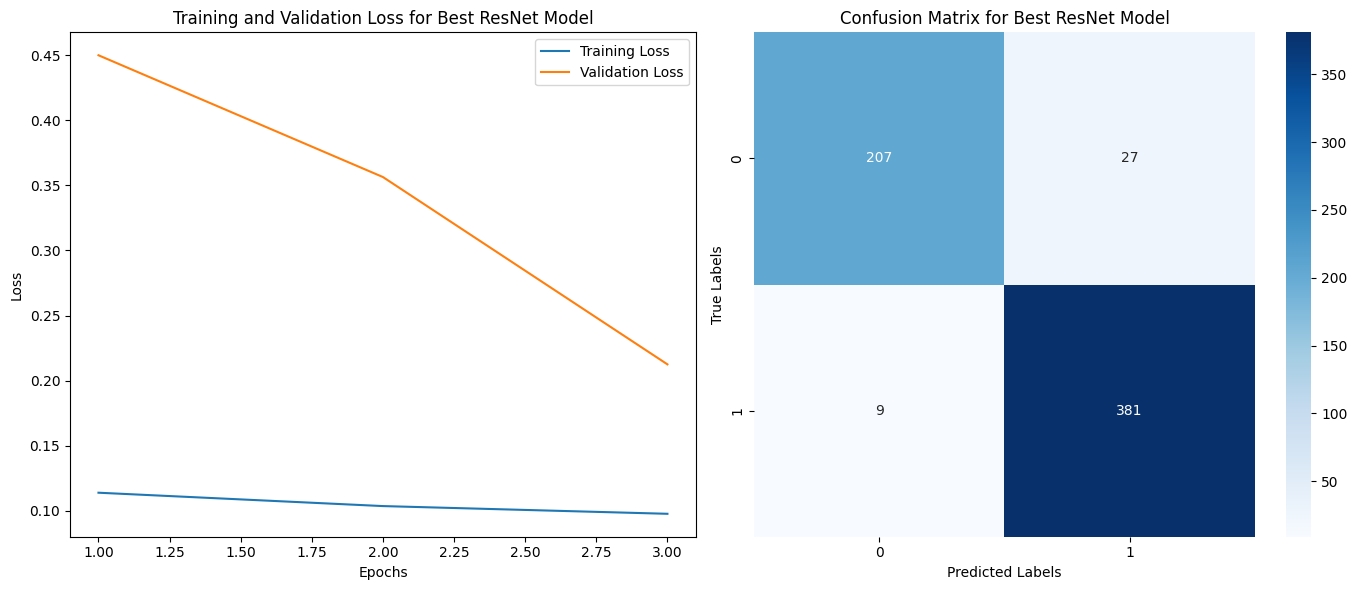

In [5]:
# Plot Training and Validation Loss for Best Model
train_losses = best_model_details["Train Loss History"]
val_losses = best_model_details["Validation Loss History"]
cm = confusion_matrix(best_model_details["All Labels"], best_model_details["All Predictions"])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Best ResNet Model")
plt.legend()

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Best ResNet Model")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")

plt.tight_layout()
plt.show()

# **Examples of Good & Bad Classifications**

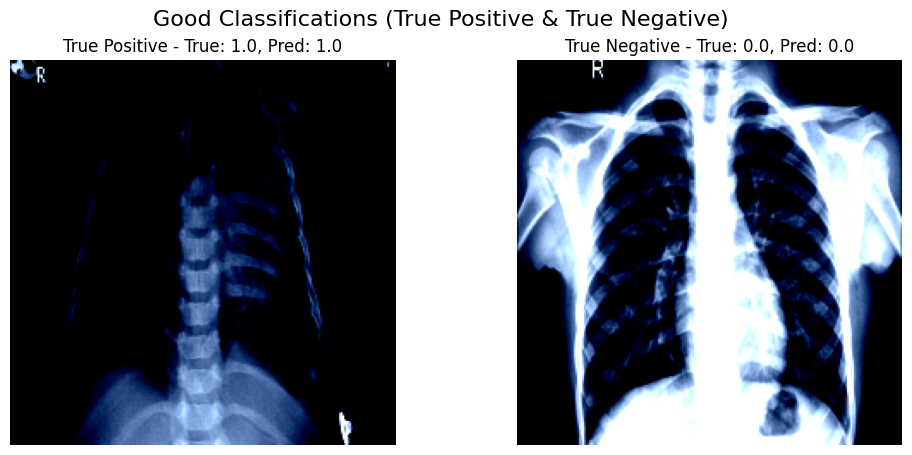

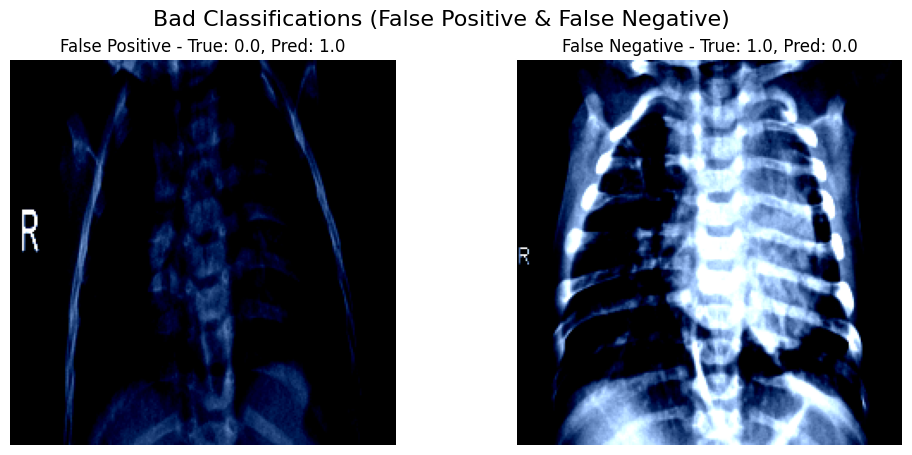

In [14]:
# Function to visualize two good and two bad classifications side by side
def show_good_and_bad_classifications(model, test_loader, device):
    model.eval()

    true_positives = []
    true_negatives = []
    false_positives = []
    false_negatives = []

    true_pos_labels = []
    true_neg_labels = []
    false_pos_labels = []
    false_neg_labels = []

    true_pos_preds = []
    true_neg_preds = []
    false_pos_preds = []
    false_neg_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()

            # Classify into the four categories
            for i in range(len(labels)):
                if predicted[i] == 1 and labels[i] == 1:
                    true_positives.append(images[i].cpu())
                    true_pos_labels.append(labels[i].cpu().item())
                    true_pos_preds.append(predicted[i].cpu().item())
                elif predicted[i] == 0 and labels[i] == 0:
                    true_negatives.append(images[i].cpu())
                    true_neg_labels.append(labels[i].cpu().item())
                    true_neg_preds.append(predicted[i].cpu().item())
                elif predicted[i] == 1 and labels[i] == 0:
                    false_positives.append(images[i].cpu())
                    false_pos_labels.append(labels[i].cpu().item())
                    false_pos_preds.append(predicted[i].cpu().item())
                elif predicted[i] == 0 and labels[i] == 1:
                    false_negatives.append(images[i].cpu())
                    false_neg_labels.append(labels[i].cpu().item())
                    false_neg_preds.append(predicted[i].cpu().item())

                if len(true_positives) >= 2 and len(true_negatives) >= 2 and len(false_positives) >= 2 and len(false_negatives) >= 2:
                    break
            if len(true_positives) >= 2 and len(true_negatives) >= 2 and len(false_positives) >= 2 and len(false_negatives) >= 2:
                break

    # Plot Good Classifications (True Positive and True Negative)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # True Positive
    axes[0].imshow(true_positives[0].permute(1, 2, 0))
    axes[0].set_title(f"True Positive - True: {true_pos_labels[0]}, Pred: {true_pos_preds[0]}")
    axes[0].axis('off')

    # True Negative
    axes[1].imshow(true_negatives[0].permute(1, 2, 0))
    axes[1].set_title(f"True Negative - True: {true_neg_labels[0]}, Pred: {true_neg_preds[0]}")
    axes[1].axis('off')

    plt.suptitle("Good Classifications (True Positive & True Negative)", fontsize=16)
    plt.show()

    # Plot Bad Classifications (False Positive and False Negative)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # False Positive
    axes[0].imshow(false_positives[0].permute(1, 2, 0))
    axes[0].set_title(f"False Positive - True: {false_pos_labels[0]}, Pred: {false_pos_preds[0]}")
    axes[0].axis('off')

    # False Negative
    axes[1].imshow(false_negatives[0].permute(1, 2, 0))
    axes[1].set_title(f"False Negative - True: {false_neg_labels[0]}, Pred: {false_neg_preds[0]}")
    axes[1].axis('off')

    plt.suptitle("Bad Classifications (False Positive & False Negative)", fontsize=16)
    plt.show()

show_good_and_bad_classifications(model, test_loader, device)
